# Higher-order (HOC) vs First-order (CE) loss

In this code session, we will see how the higher-order dependencies captured by the HOC loss allow providing more useful information to be learned during a model fine-tuning with respect to the ce loss which captures only first-order statistics.

Code inspired from:
- https://github.com/NiccoBiondi/CompatibleLifelongRepresentation
- https://github.com/miccunifi/iamcl2r

In [1]:
# !pip install --quiet continuum

In [2]:
import random
import numpy as np
from collections import defaultdict as dd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler
from torchvision.transforms import transforms

from continuum import ClassIncremental
from continuum.datasets import MNIST
from continuum import rehearsal

# reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Utility functions

Net and useful functions

In [3]:
# model lenetpp + polygon2d
"""
    LeNet++ as described in the Center Loss paper.
"""
class LeNet(nn.Module):
    # to create a 2D polygonal shape with num_classes sides
    def __init__(self, num_classes=10, feat_dim=64, batch_norm=True, **kwargs):
        self.enable_batch_norm = batch_norm
        self.feat_dim = feat_dim
        self.fixed = kwargs.get('fixed', True)

        activation_function = nn.ReLU

        super(LeNet, self).__init__()

        self.conv1_1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)
        self.batch_norm1_1 = nn.BatchNorm2d(32)
        self.act1_1 = activation_function()

        self.conv1_2 = nn.Conv2d(32, 32, 5, stride=1, padding=2)
        self.batch_norm1_2 = nn.BatchNorm2d(32)
        self.act1_2 = activation_function()

        self.conv2_1 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        self.batch_norm2_1 = nn.BatchNorm2d(64)
        self.act2_1 = activation_function()

        self.conv2_2 = nn.Conv2d(64, 64, 5, stride=1, padding=2)
        self.batch_norm2_2 = nn.BatchNorm2d(64)
        self.act2_2 = activation_function()

        self.conv3_1 = nn.Conv2d(64, 128, 5, stride=1, padding=2)
        self.batch_norm3_1 = nn.BatchNorm2d(128)
        self.act3_1 = activation_function()

        self.conv3_2 = nn.Conv2d(128, 128, 5, stride=1, padding=2)
        self.batch_norm3_2 = nn.BatchNorm2d(128)
        self.act3_2 = activation_function()

        if self.fixed:
            self.fc = nn.Linear(128 * 3 * 3, feat_dim, bias=False)
            self.fc2 = nn.Linear(feat_dim, num_classes, bias=False)

            fixed_weights = self.simplex_coordinates(num_classes=num_classes)
            self.fc2.weight.requires_grad = False  # set no gradient for the fixed classifier
            self.fc2.weight.copy_(fixed_weights)   # set the weights for the classifier
        else:
            self.fc2 = nn.Linear(128 * 3 * 3, num_classes, bias=False)

    @property
    def feature_input_size(self):
        return 128 * 3 * 3

    def forward(self, x, ind=None):
        if self.enable_batch_norm:
            out = self.act1_1(self.batch_norm1_1(self.conv1_1(x)))
            out = self.act1_2(self.batch_norm1_2(self.conv1_2(out)))
        else:
            out = self.act1_1(self.conv1_1(x))
            out = self.act1_2(self.conv1_2(out))
        out = F.max_pool2d(out, 2)

        if self.enable_batch_norm:
            out = self.act2_1(self.batch_norm2_1(self.conv2_1(out)))
            out = self.act2_2(self.batch_norm2_2(self.conv2_2(out)))
        else:
            out = self.act2_1(self.conv2_1(out))
            out = self.act2_2(self.conv2_2(out))
        out = F.max_pool2d(out, 2)
        if self.enable_batch_norm:
            out = self.act3_1(self.batch_norm3_1(self.conv3_1(out)))
            out = self.act3_2(self.batch_norm3_2(self.conv3_2(out)))
        else:
            out = self.act3_1(self.conv3_1(out))
            out = self.act3_2(self.conv3_2(out))
        out = F.max_pool2d(out, 2)
        embeddings = out.view(-1, 128 * 3 * 3)

        if self.fixed:
            embeddings = self.fc(embeddings)
        out = self.fc2(embeddings)

        return embeddings, out

    def simplex_coordinates(self, num_classes=10):
        m = num_classes - 1
        # add the credit

        x = np.zeros([m, m + 1])
        for j in range(0, m):
            x[j, j] = 1.0

        a = (1.0 - np.sqrt(float(1 + m))) / float(m)

        for i in range(0, m):
            x[i, m] = a

        #  Adjust coordinates so the centroid is at zero.
        c = np.zeros(m)
        for i in range(0, m):
            s = 0.0
            for j in range(0, m + 1):
                s = s + x[i, j]
            c[i] = s / float(m + 1)

        for j in range(0, m + 1):
            for i in range(0, m):
                x[i, j] = x[i, j] - c[i]

        #  Scale so each column has norm 1. UNIT NORMALIZED
        s = 0.0
        for i in range(0, m):
            s = s + x[i, 0] ** 2
        s = np.sqrt(s)

        for j in range(0, m + 1):
            for i in range(0, m):
                x[i, j] = x[i, j] / s

        return torch.Tensor(x.transpose())

def create_lenet(resume_path=None, starting_classes=10, feat_size=64, device=0, **kwargs):
    model = LeNet(num_classes=starting_classes, feat_dim=feat_size, **kwargs)
    if resume_path not in [None, '']:
        new_pretrained_dict = torch.load(resume_path, map_location='cpu')
        model.load_state_dict(new_pretrained_dict)

    model.cuda(device)

    return model

def l2_norm(input, axis=1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output

class BalancedBatchSampler(BatchSampler):
    def __init__(self, dataset, batch_size, n_classes, n_samples, seen_classes, rehearsal=0):
        self.dataset = dataset
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.seen_classes = seen_classes
        self.rehearsal = rehearsal
        self.n_batches = self.n_samples // self.batch_size # drop last
        if self.n_batches == 0:
            self.n_batches = 1
            self.size = self.n_samples if rehearsal == 0 else self.n_samples//2
        elif rehearsal == 0:
            self.size = self.batch_size
        else:
            self.size = self.batch_size//2
        self.index_dic = dd(list)
        self.indices = []
        self.seen_indices = []
        for index, y in enumerate(self.dataset._y):
            if y not in self.seen_classes:
                self.indices.append(index)
            else:
                self.seen_indices.append(index)

    def __iter__(self):
        for _ in range(self.n_batches):
            batch = []
            if self.rehearsal > 0:
                replace = True if len(self.seen_indices) <= self.size else False
                batch.extend(np.random.choice(self.seen_indices, size=self.size, replace=replace))
            replace = True if len(self.indices) <= self.size else False
            batch.extend(np.random.choice(self.indices, size=self.size, replace=replace))
            yield batch

    def __len__(self):
        return self.n_batches

class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Higher-order Compatibility (HOC) Loss

In [4]:
class HocLoss(nn.Module):
    def __init__(self, mu_):
        super(HocLoss, self).__init__()
        self.mu_ = mu_

    def forward(self,
                feat_new,
                feat_old,
                labels,
               ):
        loss = self._loss(feat_old, feat_new, labels)
        return loss

    def _loss(self, feat_old, feat_new, labels):
        ground_truth = torch.arange(len(labels)).type_as(labels).long()
        old_new_logits = self.mu_ * ( feat_old @ feat_new.t() )
        loss = F.cross_entropy(old_new_logits, ground_truth)
        return loss


## Training Loop
2 tasks:
- first 5 MNIST classes
- second 5 MNIST classes

In [5]:
def compute_loss_values(hoc_enabled, batch_size=64, nb_epochs=5, device='cuda'):

    print(f"Loading Training Dataset")
    train_transform = [transforms.RandomCrop(28, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ]

    val_transform = [transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ]
    dataset_train = MNIST('../data', train=True, download=True)

    # create task-sets for lifelong learning
    scenario_train = ClassIncremental(dataset_train,
                                      initial_increment=5,
                                      increment=5,
                                      transformations=train_transform)

    num_classes = scenario_train.nb_classes
    nb_tasks = scenario_train.nb_tasks

    # create episodic memory dataset
    memory = rehearsal.RehearsalMemory(memory_size=200,
                                        herding_method="random",
                                        fixed_memory=True,
                                        nb_total_classes=10
                                    )

    feat_size = num_classes - 1
    if hoc_enabled:
        add_loss = HocLoss(mu_=10)
    else:
        add_loss = None

    best_acc = 0
    for task_id, train_task_set in enumerate(scenario_train):

        rp = None if task_id == 0 else ckpt_path
        new_data_ids = train_task_set.get_classes()

        net = create_lenet(resume_path=rp,
                            starting_classes=num_classes,
                            feat_size=feat_size,
                            device=device)

        if task_id > 0:
            previous_net = create_lenet(resume_path=ckpt_path,
                                        starting_classes=num_classes,
                                        feat_size=feat_size,
                                        device=device)
            previous_net.eval()
        else:
            previous_net = None

        lr = 0.1
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-04)
        scheduler_lr = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nb_epochs, eta_min=0.00001)
        criterion_cls = nn.CrossEntropyLoss().cuda(device)

        if task_id > 0:
            mem_x, mem_y, mem_t = memory.get()
            train_task_set.add_samples(mem_x, mem_y, mem_t)
            batchsampler = BalancedBatchSampler(train_task_set, n_classes=train_task_set.nb_classes,
                                                batch_size=batch_size, n_samples=len(train_task_set._x),
                                                seen_classes=seen_classes)
            train_loader = DataLoader(train_task_set, batch_sampler=batchsampler, num_workers=2)
        else:
            train_loader = DataLoader(train_task_set, batch_size=batch_size, shuffle=True,
                                      drop_last=True, num_workers=2)
        print(f"Task {task_id+1} / {scenario_train.nb_tasks}", end="\r")
        loss_vals = []
        for epoch in range(nb_epochs):
            loss_vals.append(train_one_epoch(net, train_loader, optimizer, epoch, criterion_cls,
                                  previous_net, add_loss, hoc_enabled=hoc_enabled)
            )
            scheduler_lr.step()

        memory.add(*scenario_train[task_id].get_raw_samples(), z=None)
        seen_classes = torch.tensor(list(memory.seen_classes), device=device)

        ckpt_path = f'{"../output/HOC" if hoc_enabled and task_id > 0 else "../output/SCE"}_classifier_task_{task_id+1}.pth'
        torch.save(net.state_dict(), ckpt_path)

    return loss_vals


def train_one_epoch(net, train_loader, optimizer, epoch, criterion_cls, 
                    previous_net, add_loss, hoc_enabled, device='cuda'):

    loss_meter = AverageMeter()

    net.train()
    for bid, batchdata in enumerate(train_loader):

        inputs = batchdata[0].cuda(device)
        targets = batchdata[1].cuda(device)

        feature, output = net(inputs)
        loss = criterion_cls(output, targets)

        if previous_net is not None and hoc_enabled:
            with torch.no_grad():
                feature_old, logits_old = previous_net(inputs)
            norm_feature_old, norm_feature_new = l2_norm(feature_old), l2_norm(feature)
            loss_feat = add_loss(norm_feature_new, norm_feature_old, targets)
            loss = loss * 0.5 + (1 - 0.5) * loss_feat

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item(), inputs.size(0))

    print(f"Epoch {epoch+1}, Loss: {loss_meter.avg}", end="\r")
    return loss_meter.avg

In [9]:
nb_epochs = 50
hoc_loss_vals = compute_loss_values(hoc_enabled=True, nb_epochs=nb_epochs)

Loading Training Dataset
Task 1 / 2
Epoch 1, Loss: 0.6255906717715372
Epoch 2, Loss: 0.08682628903317822
Epoch 3, Loss: 0.05924923849271642
Epoch 4, Loss: 0.049081240716842334
Epoch 5, Loss: 0.043954216684438836
Epoch 6, Loss: 0.04159169332864675
Epoch 7, Loss: 0.0416078578319574
Epoch 8, Loss: 0.03511569335834838
Epoch 9, Loss: 0.03459659141973518
Epoch 10, Loss: 0.03482119257259377
Epoch 11, Loss: 0.032857552034489104
Epoch 12, Loss: 0.029193478712551957
Epoch 13, Loss: 0.02573254498063487
Epoch 14, Loss: 0.025406967968425214
Epoch 15, Loss: 0.02556355595666619
Epoch 16, Loss: 0.02197234615766727
Epoch 17, Loss: 0.020797824127325972
Epoch 18, Loss: 0.019962133656000906
Epoch 19, Loss: 0.022260806615202335
Epoch 20, Loss: 0.018934740599593835
Epoch 21, Loss: 0.0206809796874653
Epoch 22, Loss: 0.0195962358218928
Epoch 23, Loss: 0.018093306438512244
Epoch 24, Loss: 0.02032851512247887
Epoch 25, Loss: 0.015233654500376535
Epoch 26, Loss: 0.016530532495943814
Epoch 27, Loss: 0.01383851719

In [10]:
sce_loss_vals = compute_loss_values(hoc_enabled=False, nb_epochs=nb_epochs)

Loading Training Dataset
Task 1 / 2


Epoch 1, Loss: 0.6122049743087502
Epoch 2, Loss: 0.1020365188241192
Epoch 3, Loss: 0.06154970936725602
Epoch 4, Loss: 0.05246364099736361
Epoch 5, Loss: 0.04172292702222948
Epoch 6, Loss: 0.04033395395371634
Epoch 7, Loss: 0.03453234896888454
Epoch 8, Loss: 0.03248547808954952
Epoch 9, Loss: 0.02725426549450923
Epoch 10, Loss: 0.029267895493343927
Epoch 11, Loss: 0.027146209384120854
Epoch 12, Loss: 0.027561268353044194
Epoch 13, Loss: 0.02515609479199929
Epoch 14, Loss: 0.02241092902609677
Epoch 15, Loss: 0.022890164139490597
Epoch 16, Loss: 0.022694096365404946
Epoch 17, Loss: 0.021932700086615405
Epoch 18, Loss: 0.02183882671820984
Epoch 19, Loss: 0.01917568504697145
Epoch 20, Loss: 0.018957420515872403
Epoch 21, Loss: 0.021794592923158145
Epoch 22, Loss: 0.018237040974462194
Epoch 23, Loss: 0.01583230256853225
Epoch 24, Loss: 0.014125189394842313
Epoch 25, Loss: 0.014677862483767207
Epoch 26, Loss: 0.015189918995674512
Epoch 27, Loss: 0.014778690654101902
Epoch 28, Loss: 0.01104120

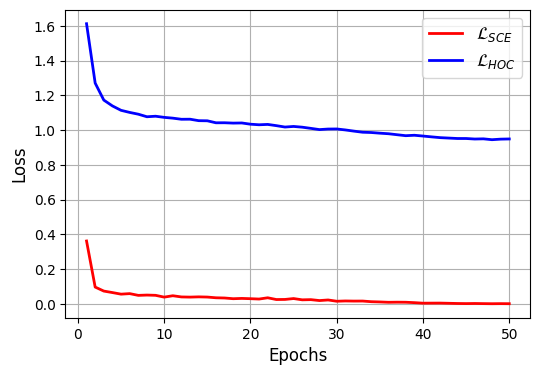

In [11]:
import matplotlib.pyplot as plt

# Example data (replace with your actual loss values)
epochs = range(1, (nb_epochs+1))

# Create the plot
plt.figure(figsize=(6, 4))

# Plot the SCE loss
plt.plot(epochs, sce_loss_vals, color='red', label=r'$\mathcal{L}_{SCE}$', linewidth=2)

# Plot the HOC loss
plt.plot(epochs, hoc_loss_vals, color='blue', label=r'$\mathcal{L}_{HOC}$', linewidth=2)

# Add labels and title
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Set the legend with custom formatting
plt.legend(fontsize=12, loc='upper right')

# Add grid
plt.grid(True)

# Show the plot
plt.show()